## Import statements

In [1]:
import ypp
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
# import pandas as pd
# import time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column
import pathlib
import sep

## Functions

In [2]:
def gaussian_x(x, height, center, width, bgoffset):
#Returns a gaussian function with the given parameters
    width = float(width)
    return (height*np.exp(-((((x - center)/width)**2)/ 2.))) + bgoffset

In [3]:
def gauss_compare(dr, sl, g_dex):
    plt.plot(dr, sl[g_dex])
    plt.plot(dr, [gaussian_x(f, gaussian_fits[g_dex][0], gaussian_fits[g_dex][1], gaussian_fits[g_dex][2], gaussian_fits[g_dex][3]) for f in dr])

### Specify data path

In [4]:
datapath = '../Methods Paper/'

### Display files in path

In [5]:
files = glob.glob(datapath + '*.fit*')
files = [os.path.basename(path) for path in files]
print(files)

['bkg_f0015.fits', 'f0009_trans.fits', 'bkg_f0009_trans.fits', 'f0015.fits', 'f0005.fits']


### Print name of current file

In [6]:
filename = 'f0009_trans.fits'
extensionless_name = filename[:filename.find('.')]
pathlib.Path(os.path.join(datapath, extensionless_name)).mkdir(exist_ok=True)
pathlib.Path(os.path.join(datapath, extensionless_name, 'data_tables')).mkdir(exist_ok=True)
print('filename =',filename)

filename = f0009_trans.fits


### Display bit range of current file

In [7]:
currentfile = datapath + filename
fits.info(currentfile)
hdul = fits.open(currentfile)
original_image_data = hdul[0].data
wcs = WCS(hdul[0])
if hdul[0].header['NAXIS'] == 3:
    print("COLOR IMAGE")
    original_image_data = original_image_data[0]
bits = hdul[0].header['BITPIX']

Filename: ../Methods Paper/f0009_trans.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     316   (3841, 3835)   int16 (rescales to uint16)   


### Display file image

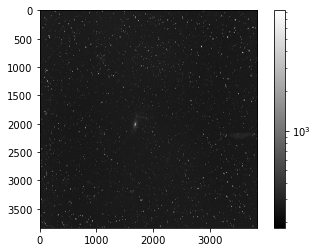

In [8]:
from ypp.utils.plot import plot_plate

image_data = np.array(np.copy(original_image_data))
plot_plate(image_data)

### Convert to positive

In [9]:
from ypp.preprocessing.crop import invert

negative = False
if negative:
    image_data = invert(image_data)
    plot_plate(image_data)

### Crop image

In [10]:
from ypp.preprocessing.crop import crop_ndarray

crop_check = False
if crop_check:
    center = (2000, 2000)
    radius = (500, 500)
    image_data = crop_ndarray(image_data, center, radius)
    plot_plate(image_data)

### Get plate specs

In [11]:
plate_median = np.median(image_data)
plate_width = len(image_data)

### Extract plate objects

In [12]:
from ypp.matching.sextract import sextract_world_locs, sextract_objects
objects = sextract_objects(image_data, 3)
coords = sextract_world_locs(image_data, 3., wcs)

### Query star catalogs

In [13]:
from ypp.matching.query import get_plate_bounds

ra_bounds, dec_bounds = get_plate_bounds(image_data, wcs)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [14]:
from ypp.matching.query import SDSS_query

result = SDSS_query(ra_bounds, dec_bounds)
clean_mask = result['clean'] != 0
result = result[clean_mask]
print(len(result))

13029


### Match plate objects to catalog

In [15]:
catalog = SkyCoord(result["ra"], result["dec"], unit=u.deg)
idx, d2d, d3d = coords.match_to_catalog_sky(catalog)

In [16]:
sources = result[idx]
sources["plate_ra"] = coords.ra
sources["plate_dec"] = coords.dec
sources["plate_sep"] = d2d
sources['plate_x'] = objects['x']
sources['plate_y'] = objects['y']

center = (2000, 2000)
sources["center_dist"] = np.sqrt((objects['x'] - center[0])**2 + (objects['y'] - center[1])**2)

### Aperture photometry

In [17]:
# radius_unit = plate_width / plate_width_wcs
# aperture_radius = 0.004 * radius_unit
# buffer_radius = 0.006 * radius_unit
# background_radius = 0.008 * radius_unit
from ypp.matching.sextract import sextract_magnitudes

constant = 25
fluxes = sextract_magnitudes(image_data, 4, 20, 30)

sources["flux"] = fluxes

nan_mask = fluxes > 0

sources = sources[nan_mask]
sources["plate_mag"] = constant - 2.5*np.log10(sources["flux"])

In [18]:
sources['umg'] = sources['u'] - sources['g']
sources['pmg'] = sources['plate_mag'] - sources['g']
#SDSS_corrected = [SDSS_mags_g[i] * (0.2 * (SDSS_mags_u[i] - SDSS_mags_g[i])) for i in range(len(SDSS_mags_g))]

#master_table.write(datapath + '/data_tables/' + extensionless_name + '_matched.csv', format='csv', overwrite=True)

In [19]:
from astropy import table
sorted_sources = sources.group_by(['objid', 'g'])
sources = table.unique(sorted_sources, keys='objid')

In [20]:
radius_mask = sources['center_dist'] < 250
sources = sources[radius_mask]

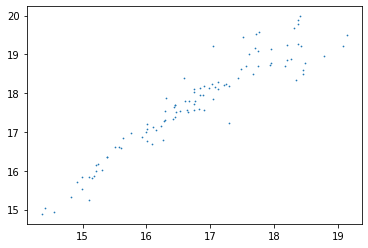

In [21]:
from astropy.stats import sigma_clip

no_outliers_mask = ~sigma_clip(sources['g'] - sources['plate_mag'], 3., masked=True).mask
good_sources = sources[no_outliers_mask]
plt.scatter(good_sources['plate_mag'], good_sources['g'], s=0.5)
# xs = np.linspace(10, 20, 100)
# ys = xs * p[0] + p[1]
# plt.plot(xs, ys)

In [22]:
gp_p = np.polyfit(good_sources['plate_mag'], good_sources['g'], deg=2)

gp_curve = lambda x: gp_p[0]*x**2 + gp_p[1]*x + gp_p[2]

gp_curve_xs = np.linspace(12, 20, 100)
gp_curve_ys = gp_curve(gp_curve_xs)

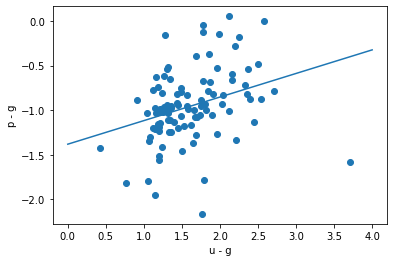

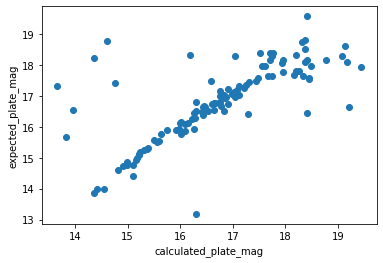

In [23]:
pg_up_p = np.polyfit(good_sources['u'] - good_sources['g'], good_sources['plate_mag'] - good_sources['g'], deg=1)

expected_pg = lambda x: pg_up_p[0]*x + pg_up_p[1]
expg_curve_xs = np.linspace(0, 4, 100)
expg_curve_ys = expected_pg(expg_curve_xs)

sources['expected_plate_mag'] = expected_pg(sources['u'] - sources['g']) + sources['g']

plt.xlabel('u - g')
plt.ylabel('p - g')
plt.scatter(good_sources['u'] - good_sources['g'], good_sources['plate_mag'] - good_sources['g'])
plt.plot(expg_curve_xs, expg_curve_ys)
plt.show()

plt.xlabel('calculated_plate_mag')
plt.ylabel('expected_plate_mag')
plt.scatter(sources['plate_mag'], sources['expected_plate_mag'])
plt.show()

In [24]:
outliers_mask = sigma_clip(sources['expected_plate_mag'] - sources['plate_mag'], 3., masked=True).mask
outlier_sources = sources[outliers_mask]

In [25]:
print(outlier_sources['ra'], outlier_sources['dec'])

       ra       
----------------
 339.35900459929
339.343737765628
339.439746153587
339.434158746666
339.414270840149
339.432453223429
339.400820769205
339.380825614855
339.377035119987
339.360837742443
339.366898339018
339.382519181965
339.520547939628       dec       
----------------
34.4812777996947
34.4279530341279
 34.467306481291
34.4100064407558
34.4392173555595
34.4354544383171
34.4007656812465
34.3829427465691
34.4540345205827
34.4300821786849
34.4030812277254
34.4048646654764
34.4697558831652


In [26]:
print(sources['plate_sep'].to(u.arcsec))
print(outlier_sources['plate_sep'].to(u.arcsec))

[5.59984164e-01 1.07030546e+00 6.24546021e+01 7.61329647e+01
 2.91619942e+01 3.10788869e-01 1.09980607e-01 1.20782670e+00
 1.07552351e+00 1.16706532e+00 2.93433810e-01 5.81120186e-01
 1.17764476e+00 7.62134339e-01 1.34399385e+00 6.85525688e-01
 7.27150185e-01 4.88098118e-01 1.27789799e+00 1.05390440e+00
 8.11068666e+01 5.94152718e-01 1.52930923e+00 8.52381030e-01
 7.44458702e-01 1.53318062e+00 6.41457080e-01 1.52455708e-01
 1.37399205e-01 3.53156164e-01 1.52576047e+01 2.50274499e+01
 3.67742684e+01 3.00016877e+00 6.87088905e-01 4.40087714e-01
 8.81486137e-01 8.54901028e-01 2.29051004e-01 4.10959493e-01
 7.19827850e-01 3.16834084e+01 3.91981486e-01 6.69903393e+01
 1.03122762e+00 8.90437969e-01 1.06418136e+00 3.34438024e-01
 5.86854227e-01 1.15581803e+00 2.17018207e-01 3.44582975e+01
 9.80979846e-02 1.14626519e-01 9.95208240e-01 5.25526333e-01
 1.11010597e+00 6.39864252e-01 7.87106547e-01 1.86183832e-01
 5.17891277e-01 4.92791302e-01 1.70983961e+01 4.34266831e-01
 3.95558528e-01 8.180905

In [27]:
def img_cutout(data, ra, dec, wcs, size=(20, 20)):
    pixel_loc = wcs.all_world2pix([[ra, dec]], 1)[0]
    x_bounds = (int(pixel_loc[0] - size[0]), int(pixel_loc[0] + size[0]))
    y_bounds = (int(pixel_loc[1] - size[1]), int(pixel_loc[1] + size[1]))
    plt.imshow(data[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]])
    plt.show()

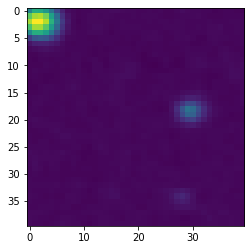

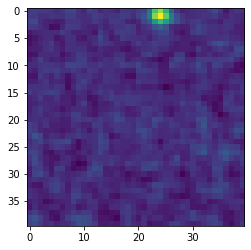

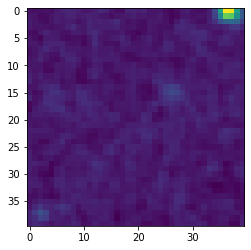

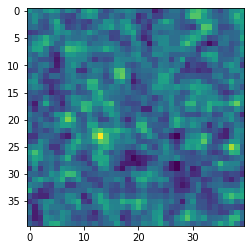

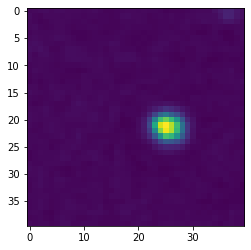

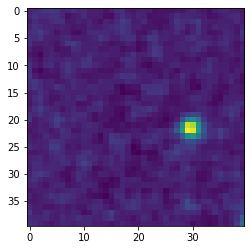

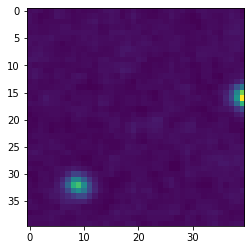

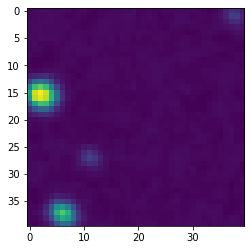

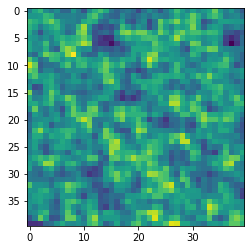

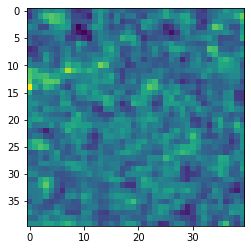

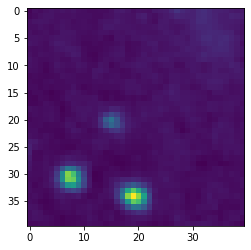

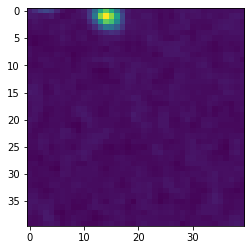

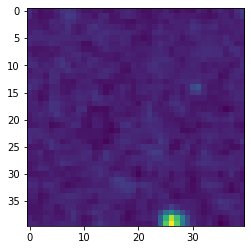

In [28]:
for source in outlier_sources:
    img_cutout(image_data, source['ra'], source['dec'], wcs)

In [ ]:
plt.imshow()

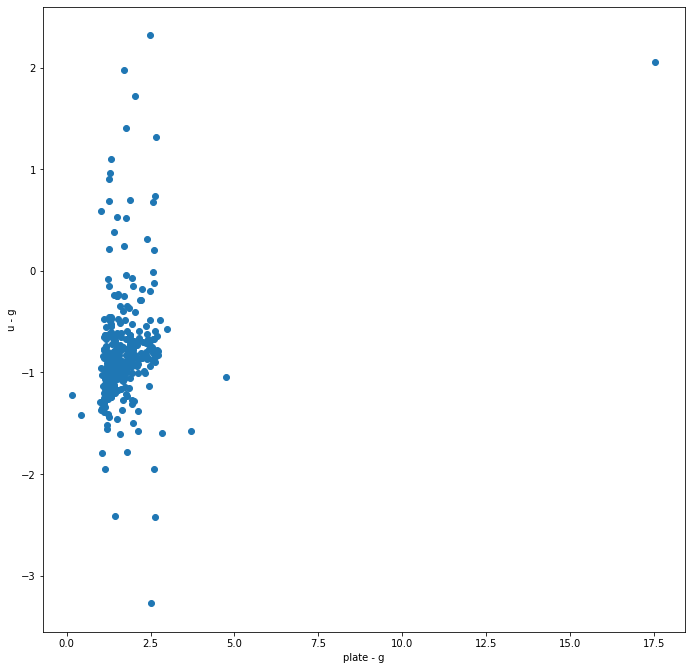

In [25]:
plt.figure(figsize=(11.5, 11.5))
plt.gca().set_ylabel('u - g')
plt.gca().set_xlabel('plate - g')
# plt.xlim(0.75, 2)
# plt.ylim(7, 10)
# plt.gca().set_ylabel('u - g')
# plt.gca().set_xlabel('g - plate')
plt.scatter(sources['umg'], sources['pmg'])
plt.show()

In [ ]:
plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('log10(flux)')
plt.gca().set_xlabel('SDSS g magnitudes')
plt.scatter(master_table['g'], master_table['calculated_mags'], c='red')

In [ ]:
def color_correction(x):
    h1 = 0.9
    k1 = 8.7
    h2 = 2.
    k2 = 8.1
    slope = (k2 - k1) / (h2 - h1)
    return (slope*(h1 - x)) + k1

master_table['color_correction'] = color_correction(np.array(master_table['g']))
master_table['corrected_mags'] = master_table['color_correction'] + master_table['calculated_mags']

plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('SDSS g magnitudes')
plt.gca().set_xlabel('log10(flux)')
plt.scatter(master_table['corrected_mags'], master_table['g'], c='red')

In [ ]:
# 1: 167.86885, 28.77947
# 2: 167.59673, 28.73918
# 3: 167.68761, 28.61742

three_coords = [(167.86876, 28.77950), (167.68729, 28.61764), (167.59663, 28.73876)]
three_ids = star_info_SDSS['objid'][quick_match(three_coords, star_info_SDSS_coords, 0.1, 0.5)]
three_mags = np.array([master_table['corrected_mags'][np.where(master_table['objid'] == i)][0] for i in three_ids])
# for three_id in three_ids:
#     objid_found = 0
#     for i in range(len(master_table)):
#         if master_table['objid'][i] == three_id:
#             three_mags.append(master_table['g'][i])
#             objid_found = 1
#     if not objid_found:
#         three_mags.append(-1)
print(three_mags)
print(calibrate_mag(three_mags))

### Gaussian fitting

In [ ]:
domain_half = 20
d_range = range(0 - domain_half, domain_half)
slices = []
gaussian_fits = []
for i in range(len(star_cm_locations)):
    if((star_x_cm_location[i] < (len(image_data[0]) - domain_half)) and (star_x_cm_location[i] > domain_half)):
        star_slice = image_data[int(star_y_cm_location[i])][int(star_x_cm_location[i] - domain_half) : int(star_x_cm_location[i] + domain_half)]
        slices.append(star_slice)
        params, params_cov = opt.curve_fit(gaussian_x, d_range, star_slice, [10000, 0, 1, plate_median])
        gaussian_fits.append(params)
gaussian_fits = np.asarray(gaussian_fits)

### CSV writing